In [1]:


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os
import datetime
from sklearn.mixture import GaussianMixture 
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline



In [2]:
def loadData(file):
    data = pd.read_csv(file,parse_dates=['Date'])
    data = data[data['Date']>='2018-01-01']
    data = data.groupby(['Date','DOLocationID']).sum().reset_index().pivot(index='Date', columns='DOLocationID', values='vehicle_count').reset_index()
#     print('Days: ',len(set(data.Date)))
    
    return data


def zscoreNormalizeSpatial(matrix):
    for i in range(matrix.shape[0]):
        matrix[i, :] = (matrix[i, :] - matrix[i, :].mean()) / (matrix[i, :].std()+1e-10)
        
    return matrix

def getPCAFeatures(matrix, n=10):
    pca = PCA(n_components=n)
    pca.fit(matrix)
    reducedMatrixPCA = pca.transform(matrix)
    reducedMatrixPCA.shape

    reducedDict = {str(i+1):reducedMatrixPCA[:,i] for i in range(reducedMatrixPCA.shape[1])}
    reducedDf = pd.DataFrame(reducedDict)
    reducedDf.index = data.index
    return reducedDf

def getPCACost(matrix,data, n=10):
    pca = PCA(n_components=n)
    pca.fit(matrix)
    reducedMatrixPCA = pca.transform(matrix)
    reconMatrixPCA = pca.inverse_transform(reducedMatrixPCA)
    reconCost = reconMatrixPCA - matrix
    reducedDf = pd.DataFrame(reconCost)

#     reconCost = np.sum(reconMatrixPCA - matrix, axis=1)
#     reducedDict = {'rec_cost':reconCost}
#     reducedDf = pd.DataFrame(reducedDict)
    reducedDf['date'] = data.Date
    return reducedDf

In [3]:
file = '/home/urwa/Documents/Projects/NYU Remote/project/data/JfkVehiceByHour.csv'
data = loadData(file)
matrix = data.drop(columns='Date').values
matrix = zscoreNormalizeSpatial(matrix)
matrix.shape

(365, 258)

In [4]:
n = 10
pca = PCA(n_components=n)
pca.fit(matrix)
reducedMatrixPCA = pca.transform(matrix)
reconMatrixPCA = pca.inverse_transform(reducedMatrixPCA)
reconCost = reconMatrixPCA - matrix
reconCost = np.sum(np.abs(reconMatrixPCA - matrix), axis=1)
reducedDict = {'rec_cost':reconCost}
reducedDf = pd.DataFrame(reducedDict)
reducedDf['date'] = data.Date

In [5]:
reducedDf.head(2)

,rec_cost,date
0,25.864046,2018-01-01
1,19.288019,2018-01-02


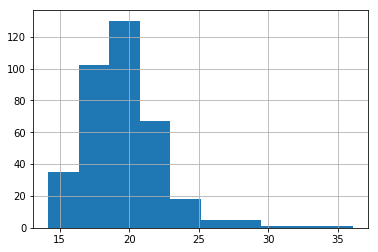

In [6]:
reducedDf.rec_cost.hist()

In [7]:
y = reducedDf.drop(columns=['date']).values
y.shape

(365, 1)

In [8]:
if len(y.shape) == 1 or y.shape[1] == 1:
    y = np.array(y).reshape(-1,1)
y.shape

(365, 1)

In [9]:
iterN = 20
pval = 0.01
ncom = 2

In [14]:
rind = np.array(range(y.shape[0]))
#clustering model
gm=GaussianMixture(n_components=ncom,n_init=100,max_iter=1000,random_state=0) 
for i in range(iterN): #iterate
    print('Iteration {}'.format(i+1))  
    print('input shape: ',str(y[rind,:].shape))
    clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
    print(clustering.lower_bound_)
    print(clustering.aic(y[rind,:]))
    l=clustering.score_samples(y) 
    l = clustering.predict_proba(y)
    print(l.sum(axis=1))
    print(l.shape)
    l = l.max(axis=1)
    print(l.shape)
#     print(sorted(l)[:15])
    
    #estimate likelihood for each point
#     l2 = clustering.score_samples(y[rind,:])
    Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
    
    rind0=0+rind
    rind=l>   0.9 #Lthres #non-anomalous points

#     print(rind0)
#     print("samples: ",str(y[rind0,:].shape[0]))
    print(len(l))
    print('filtered: ',str(sum(rind)))
    print('thresh: ',str(Lthres))
    
    print('index:',str(int(len(l)*pval)))
    
    if all(rind==rind0):
        print('Convergence in {} iterations'.format(i+1))
        break
    

Iteration 1
input shape:  (365, 1)
-2.364192821257588
1735.2340840259194
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

-2.309707683700715
1663.646648207713
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

-2.299811327950937
1652.0057453375198
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

KeyboardInterrupt: 